# Preprocessing: convert image and extract mask

## Example

This notebook shows how to convert (TCGA) svs file to a dense pyramid tif file.
Furthermore we show how to (naively) create a tissue-background mask

**The resulting .tif and _mask.tif files can be used in to run the HookNet-TLS algorithm.**


requirements:
 - numpy
 - pyvips
 - matplotlib
 - skimage
 - wholeslidedata

In [1]:
from pathlib import Path

import numpy as npq
import pyvips
from matplotlib import pyplot as plt
from skimage import color
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_holes, remove_small_objects
from wholeslidedata import WholeSlideImage

## Converting to tif

First download the svs file from gdc portal: https://portal.gdc.cancer.gov/files/d5d00824-8f67-4a9d-b772-71569d3659c5

Convert the svs file to tif such that we get a dense pyramid, i.e., all spacings/mpps with a factor of two are available starting from specified spacing/mpp.

In this case we are going to convert the svs to tif starting from ~0.5. The actual/real spacing is determinded by the orginal svs file. As you will see below the actual spacing/mpp will be 0.5040048203336019. The tif will contain all down downsampled factor x2 levels, i.e., [0.504..., 1.008..., 2.016..., 4.032..., 8.065..., ... etc]


**Run the following command (script is located in [wholeslidedata package](https://github.com/DIAGNijmegen/pathology-whole-slide-data))**

```bash
python ./wholeslidedata/scripts/save_image_at_spacing.py \
 -i "./TCGA-18-3406-01Z-00-DX1.8D07F006-425C-4724-BBB3-5BA099401234.svs" \
 -s 0.5
```

## Checking converted tif file

In [2]:
print("\nOriginal SVS\n---------")
wsi_svs = WholeSlideImage('./TCGA-18-3406-01Z-00-DX1.8D07F006-425C-4724-BBB3-5BA099401234.svs')
print("\tSpacings/MPPs: ", wsi_svs.spacings)
print("\tShapes: ", wsi_svs.shapes)

print("\nConverted TIF\n---------")
wsi_tif = WholeSlideImage('./converted_0-5/TCGA-18-3406-01Z-00-DX1.8D07F006-425C-4724-BBB3-5BA099401234.tif')
print("\tSpacings/MPPs: ", wsi_tif.spacings)
print("\tShapes: ", wsi_tif.shapes)



Original SVS
---------
	Spacings/MPPs:  [0.252, 1.0080096718240887, 4.032130575307781, 8.065499420196804]
	Shapes:  ((128273, 87765), (32068, 21941), (8017, 5485), (4008, 2742))

Converted TIF
---------
	Spacings/MPPs:  [0.5040048203336019, 1.0080096406672039, 2.016065225256043, 4.032130450512086, 8.065499170149257, 16.130998340298515, 32.27377173930844, 64.59474700345122, 129.31853533687013, 259.3978804269525]
	Shapes:  ((64136, 43882), (32068, 21941), (16034, 10970), (8017, 5485), (4008, 2742), (2004, 1371), (1002, 685), (501, 342), (250, 171), (125, 85))


## Creating background-tissue mask (naively)

Processing spacing:  8.065499170149257


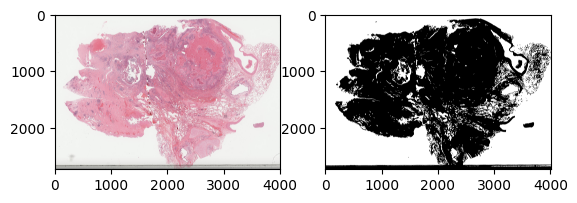

In [3]:
processing_spacing = 8.0
processing_spacing = wsi_tif.get_real_spacing(processing_spacing)
print("Processing spacing: ", processing_spacing)


processing_slide = wsi_tif.get_slide(processing_spacing)
grey_processing_slide = color.rgb2gray(processing_slide)

processing_slide_mask = grey_processing_slide > threshold_otsu(grey_processing_slide)
processing_slide_mask = remove_small_objects(processing_slide_mask)
processing_slide_mask = remove_small_holes(processing_slide_mask)

fig, ax = plt.subplots(1,2)
ax[0].imshow(processing_slide)
ax[1].imshow(processing_slide_mask, cmap='gray')
plt.show()

## Saving mask to tif

In [4]:
tif_mask_spacing = 2.0
tif_mask_spacing = wsi_tif.get_real_spacing(tif_mask_spacing)
print("Tif mask spacing: ", tif_mask_spacing)

upsample_ratio = processing_spacing / tif_mask_spacing
print("Upsample ratio: ", upsample_ratio)


mask_img = pyvips.Image.new_from_array(processing_slide_mask)
mask_img_upscaled = mask_img.resize(upsample_ratio, kernel = pyvips.enums.Kernel.NEAREST)
print("Upscaled mask: ", mask_img_upscaled)

output_path = f"{Path(wsi_tif.path).stem}_mask.tif"
xres = tif_mask_spacing 
yres = tif_mask_spacing
mask_img_upscaled.tiffsave(
    output_path,
    compression="lzw",
    tile=True,
    tile_width=512,
    tile_height=512,
    pyramid=True,
    bitdepth=8,
    bigtiff=True,
    depth="onetile",
    background=[0],
    resunit="cm",           # NOTE: cm is required because "asap" backend wont work correctly with inch
    xres=1000/xres,
    yres=1000/yres,
)

Tif mask spacing:  2.016065225256043
Upsample ratio:  4.000614200924441
Upscaled mask:  <pyvips.Image 16034x10970 uchar, 1 bands, b-w>


## Check mask metadata


**NOTE:** Please note that opening the mask file with "openslide" or "asap" backend works OK to check metadata.

**However, only the "asap" backend is able to extract (patch/tile) data from the tif file.**


In [5]:
wsm = WholeSlideImage("./TCGA-18-3406-01Z-00-DX1.8D07F006-425C-4724-BBB3-5BA099401234_mask.tif")

print("Mask tif\n---------")
print("\tSpacings/MPPs: ", wsm.spacings)
print("\tShapes: ", wsm.shapes)

Mask tif
---------
	Spacings/MPPs:  [2.016065323666589, 4.032130647333178, 8.065499558559317, 16.130999117118634, 32.273773025188845, 64.59474850182393]
	Shapes:  ((16034, 10970), (8017, 5485), (4008, 2742), (2004, 1371), (1002, 685), (501, 342))
